In [1]:
pip install torch numpy matplotlib

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [9]:
class BharatSpatialDataset(Dataset):
    def __init__(self, num_samples=1000, grid_size=16):
        self.num_samples = num_samples
        self.grid_size = grid_size

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Simulated satellite-style spatial grid
        spatial_grid = np.random.rand(1, self.grid_size, self.grid_size)

        # Simulated IoT sensor signals:
        # [traffic_density, AQI, humidity, temperature]
        sensor_data = np.random.rand(4)

        # Congestion risk logic
        risk_score = (sensor_data[0] + np.mean(spatial_grid)) / 2
        label = 1 if risk_score > 0.6 else 0

        return (
            torch.tensor(spatial_grid, dtype=torch.float32),
            torch.tensor(sensor_data, dtype=torch.float32),
            torch.tensor(label, dtype=torch.long),
        )

dataset = BharatSpatialDataset()
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [10]:
class SpatialEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((4, 4))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        return torch.flatten(x, start_dim=1)


class SensorEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 32)
        self.fc2 = nn.Linear(32, 32)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x


class AttentionFusion(nn.Module):
    def __init__(self, spatial_dim, sensor_dim):
        super().__init__()
        self.attn = nn.Linear(spatial_dim + sensor_dim, 1)

    def forward(self, spatial_feat, sensor_feat):
        combined = torch.cat([spatial_feat, sensor_feat], dim=1)
        weight = torch.sigmoid(self.attn(combined))
        fused = combined * weight
        return fused


class BharatSpatialNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.spatial_encoder = SpatialEncoder()
        self.sensor_encoder = SensorEncoder()
        self.fusion = AttentionFusion(32*4*4, 32)
        self.classifier = nn.Linear((32*4*4)+32, 2)

    def forward(self, spatial, sensor):
        spatial_feat = self.spatial_encoder(spatial)
        sensor_feat = self.sensor_encoder(sensor)
        fused_feat = self.fusion(spatial_feat, sensor_feat)
        return self.classifier(fused_feat)


model = BharatSpatialNet().to(device)
print(model)

BharatSpatialNet(
  (spatial_encoder): SpatialEncoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (sensor_encoder): SensorEncoder(
    (fc1): Linear(in_features=4, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
  )
  (fusion): AttentionFusion(
    (attn): Linear(in_features=544, out_features=1, bias=True)
  )
  (classifier): Linear(in_features=544, out_features=2, bias=True)
)


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
torch.save(model.state_dict(), "bharat_spatial_model.pth")

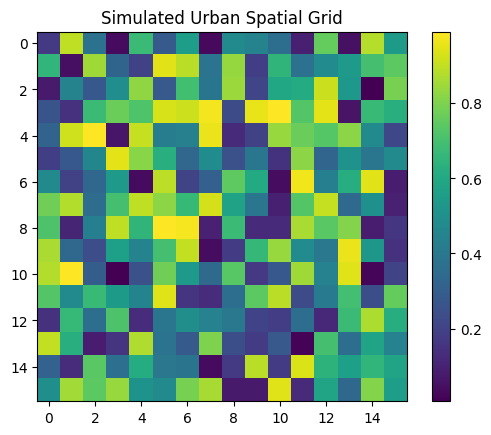

In [13]:
sample_spatial, _, _ = dataset[0]

plt.imshow(sample_spatial[0], cmap='viridis')
plt.title("Simulated Urban Spatial Grid")
plt.colorbar()
plt.show()

In [12]:
correct = 0
total = 0

model.eval()

with torch.no_grad():
    for spatial, sensor, label in train_loader:
        spatial = spatial.to(device)
        sensor = sensor.to(device)
        label = label.to(device)

        outputs = model(spatial, sensor)
        _, predicted = torch.max(outputs, 1)

        total += label.size(0)
        correct += (predicted == label).sum().item()

print("Accuracy:", 100 * correct / total)

Accuracy: 96.8


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 8

for epoch in range(epochs):
    total_loss = 0

    for spatial, sensor, label in train_loader:
        spatial = spatial.to(device)
        sensor = sensor.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        outputs = model(spatial, sensor)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f}")

Epoch 1/8 | Loss: 19.5796
Epoch 2/8 | Loss: 18.4399
Epoch 3/8 | Loss: 17.3831
Epoch 4/8 | Loss: 14.7273
Epoch 5/8 | Loss: 8.8114
Epoch 6/8 | Loss: 5.8950
Epoch 7/8 | Loss: 4.7452
Epoch 8/8 | Loss: 3.7804



# 🇮🇳 BharatSpatialNet
## Multi-Modal Spatial Intelligence for Smart Urban Monitoring in India

### Abstract
Rapid urbanization in Indian metropolitan regions such as Bengaluru, Delhi, and Mumbai has intensified challenges related to congestion, air quality, and infrastructure stress. This project proposes BharatSpatialNet, a multi-modal deep learning framework that integrates spatial grid representations with IoT-based sensor signals to predict urban congestion risk.

The model leverages convolutional neural networks (CNNs) for spatial encoding and a fully connected embedding pipeline for sensor fusion. An attention-based fusion mechanism dynamically weighs multi-modal inputs to improve risk classification performance.

This work serves as a prototype intelligent system for smart-city deployments and edge-based urban monitoring solutions.

## Problem Statement

Given:

- A spatial representation of an urban region (simulated satellite grid)
- IoT sensor signals including:
  - Traffic density
  - Air Quality Index (AQI)
  - Humidity
  - Temperature

Predict:

- Binary congestion risk level:
  - 0 → Low Risk
  - 1 → High Risk

The challenge lies in effectively fusing heterogeneous modalities:
Spatial features (image-like grids) and structured sensor data.

## Model Architecture

BharatSpatialNet consists of four components:

### 1️⃣ Spatial Encoder
- Convolutional layers extract spatial patterns
- Adaptive pooling compresses spatial representations

### 2️⃣ Sensor Encoder
- Fully connected layers embed structured sensor data

### 3️⃣ Attention-Based Fusion
- Learns adaptive weighting of spatial + sensor embeddings
- Encourages dynamic modality importance

### 4️⃣ Classification Head
- Outputs binary congestion prediction

The architecture enables multi-modal spatial reasoning.